In [19]:
!pip install japanize-matplotlib &>/dev/null # 日本語フォントをダウンロードする。
from matplotlib import pylab as plt
import japanize_matplotlib
plt.rcParams["figure.dpi"]=140

import numpy as np
import pandas as pd

from pprint import pprint as pprint

def calcSIR(S,I,R,dI,dR,dS,BETA,GAMMA,MaxdI=float('inf'),lockdownrate=0.7):
    rawBETA=np.copy(BETA)
    lockdownBETA=np.copy(BETA)*lockdownrate
    for t in range(1,NUM_OF_DAYS): #t日目について
        #dS.append(-BETA*(S[-1]*I[-1]))#(4,1)*(4,2)=>(4,2)．(4,2)*(4,2)=>(4,2)
        dS.append(-BETA*(S[-1]*np.sum(I[-1])))#(4,1)*(4,2)=>(4,2)．(4,2)*(4,2)=>(4,2)
        dR.append(I[-1]*GAMMA)
        dI.append(-dS[-1]-dR[-1])#-(4,2)-(4,2)=>(4,2)

        s=S[-1]+np.sum(dS[-1],axis=1,keepdims=True)
        i=I[-1]+dI[-1]
        S.append(np.where(0 < s, s, 0))
        I.append(np.where(0 < i, i, 0))
        R.append(R[-1]+np.sum(dR[-1],axis=1,keepdims=True))

        for k, p in enumerate(GROUPS):
            if(MaxdI/1000000*N[k]<abs(np.sum(dS[-1],axis=1)[k])):
                BETA[k]=lockdownBETA[k]
            else:
                BETA[k]=rawBETA[k]

In [26]:
NUM_OF_DAYS=300
GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
#GAMMA=np.array([[1/15.7,1/15.7]])#回復率．γ=1/(感染者の平均回復日数)とすることができるらしいので．回復日数を15.7日として
GAMMA=np.array([[1/4]]) #回復率．γ=1/(感染から隔離されるまでの日数)とすることができるらしいので．11区分

R0=np.array([[1.23]])
#1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
#0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)

#N=np.array([[10000000], # 東京 (総人11口，推計人口2021年4月1日)
#            [10000000], # 埼玉
#            [10000000], # 千葉
#            [10000000]])# 神奈川

#https://www.bousai.metro.tokyo.lg.jp/_res/projects/default_project/_page_/001/013/860/47kai/2021052704.pdf
N=np.array([[524939+499632], # <10
            [493559+566729], # 10-19
            [753698+863678], # 20-29
            [969877+1038390], # 30
            [1154214+1048170], # 40
            [891332+722755], # 50
            [725312+854575], # 60
            [713342+583971], # 70
            [449314+261441], # 80
            [108999+28732], # 90
            [5142]])# >=100

# 罹患率10万人あたり https://datastudio.google.com/u/0/reporting/c1dfbd03-0aa7-457d-81d2-3ca5be34706b/page/KNtNB?s=mM99TXFS68A
# 「同性同世代10万人あたり何人感染しているか。……かかりやすさを比較」
ALPHA=np.array([[413.05+399.74], # <10
                [871.69+749.47], # 10-19
                [2551.66+2330.63], # 20-29
                [1821.6+1268.86], # 30
                [1336.05+842.52], # 40
                [1249.87+922.23], # 50
                [945.98+655.33], # 60
                [748.8+566.84], # 70
                [952.52+804.37], # 80
                [1393.54+1336.56], # 90
                [2597.4+1582.82]])# >=100

ALPHA=ALPHA/np.sum(ALPHA,axis=0,keepdims=True)

S=[np.copy(N)]

# 年齢別感染者数/全感染者 東京都 直近1週間 5/18-5/24
#【感染状況】①-2 新規陽性者数（年代別）より
I=[4710*ALPHA]
R=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100

dS=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100
dI=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100
dR=[np.array([[0], # <10
            [0], # 10-19
            [0], # 20-29
            [0], # 30
            [0], # 40
            [0], # 50
            [0], # 60
            [0], # 70
            [0], # 80
            [0], # 90
            [0]])]# >100

# R0=β/γ
print("γ=",GAMMA)
print("R0*α*len(GROUPS)=",R0*ALPHA*len(GROUPS))
print("α=",ALPHA)
print("sum(α)=",np.sum(ALPHA))
print("β=R0*γ*α=",R0*GAMMA*ALPHA)

BETA=R0*GAMMA #BETA=R0*GAMMA/N (R0の定義より)
print("N=",N)
print("β=",BETA)
print("sum(β)=",np.sum(BETA))

BETA=BETA/N
print("β/N=",BETA)

GAMMA=GAMMA/11

#calcSIR(S,I,R,dI,dR,dS,BETA,GAMMA,MaxdI=1,lockdownrate=0.3)#MaxdIは人口十万人あたり
calcSIR(S,I,R,dI,dR,dS,BETA,GAMMA)#MaxdIは人口十万人あたり

print("dS[1]=",dS[1])
print("dI[1]=",dI[1])
print("dR[1]=",dR[1])
print("S[1]=",S[1])
print("I[1]=",I[1])
print("R[1]=",R[1])
print("S[1]*I[1]=",S[1]*I[1])
print("dS[-1]=",dS[-1])
print("dI[-1]=",dI[-1])
print("dR[-1]=",dR[-1])
print("S[-1]=",S[-1])
print("I[-1]=",I[-1])
print("R[-1]=",R[-1])
print("S[1]*I[1]=",S[-1]*I[-1])


γ= [[0.25]]
R0*α*len(GROUPS)= [[0.4174795 ]
 [0.83268872]
 [2.50772767]
 [1.58737643]
 [1.11899545]
 [1.11567221]
 [0.82249301]
 [0.67576216]
 [0.90240475]
 [1.40228199]
 [2.14711813]]
α= [[0.03085584]
 [0.06154388]
 [0.18534573]
 [0.11732272]
 [0.08270476]
 [0.08245914]
 [0.06079032]
 [0.04994547]
 [0.06669658]
 [0.10364242]
 [0.15869314]]
sum(α)= 1.0
β=R0*γ*α= [[0.00948817]
 [0.01892474]
 [0.05699381]
 [0.03607674]
 [0.02543171]
 [0.02535619]
 [0.01869302]
 [0.01535823]
 [0.0205092 ]
 [0.03187005]
 [0.04879814]]
N= [[1024571]
 [1060288]
 [1617376]
 [2008267]
 [2202384]
 [1614087]
 [1579887]
 [1297313]
 [ 710755]
 [ 137731]
 [   5142]]
β= [[0.3075]]
sum(β)= 0.3075
β/N= [[3.00125614e-07]
 [2.90015543e-07]
 [1.90122767e-07]
 [1.53117091e-07]
 [1.39621428e-07]
 [1.90510177e-07]
 [1.94634173e-07]
 [2.37028381e-07]
 [4.32638532e-07]
 [2.23261285e-06]
 [5.98016336e-05]]
dS[1]= [[-1448.325]
 [-1448.325]
 [-1448.325]
 [-1448.325]
 [-1448.325]
 [-1448.325]
 [-1448.325]
 [-1448.325]
 [-1448.325

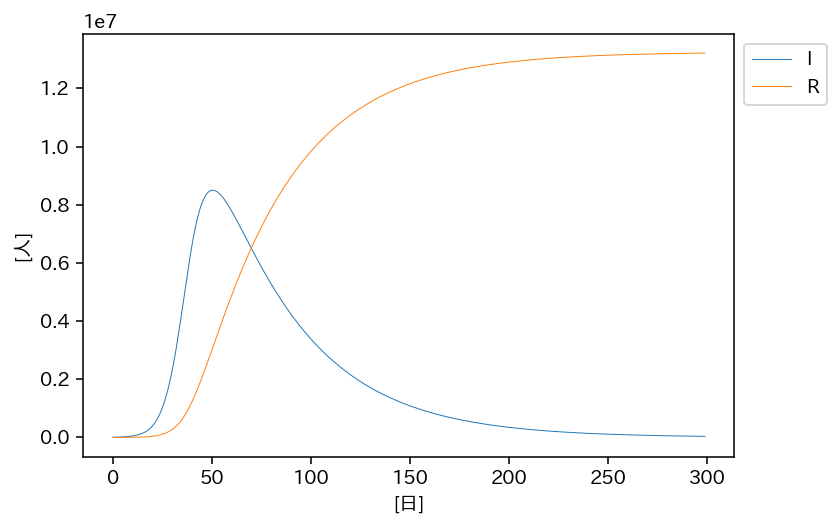

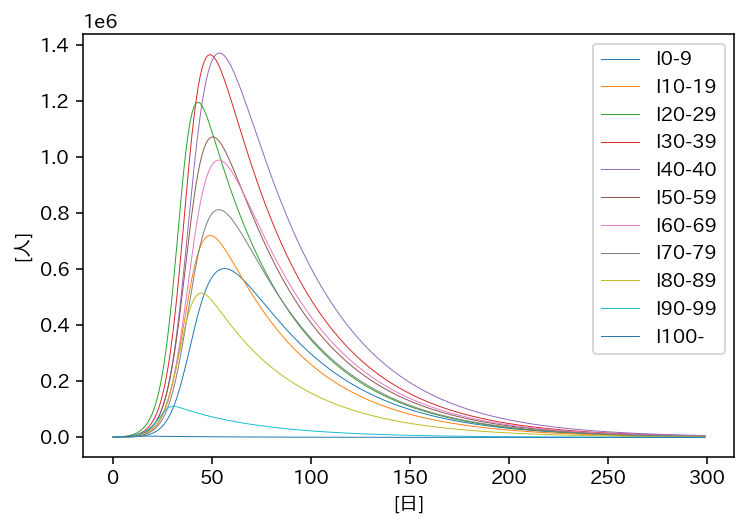

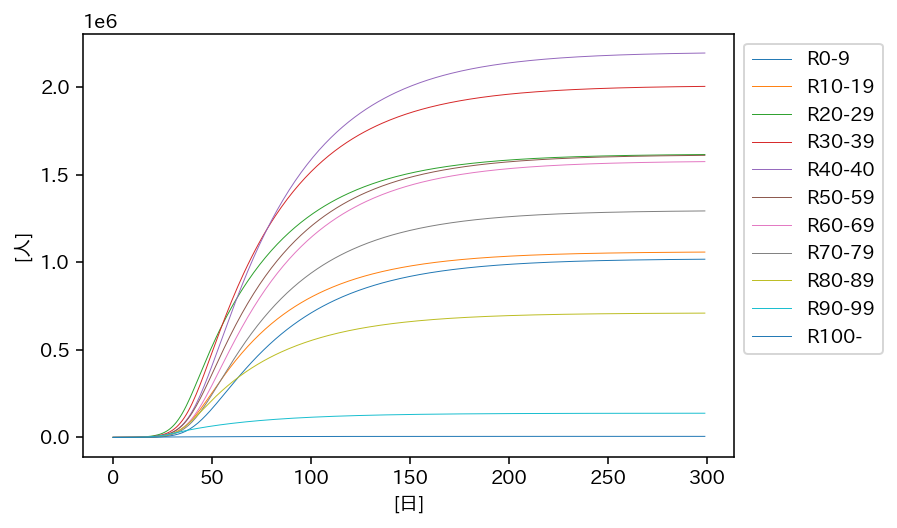

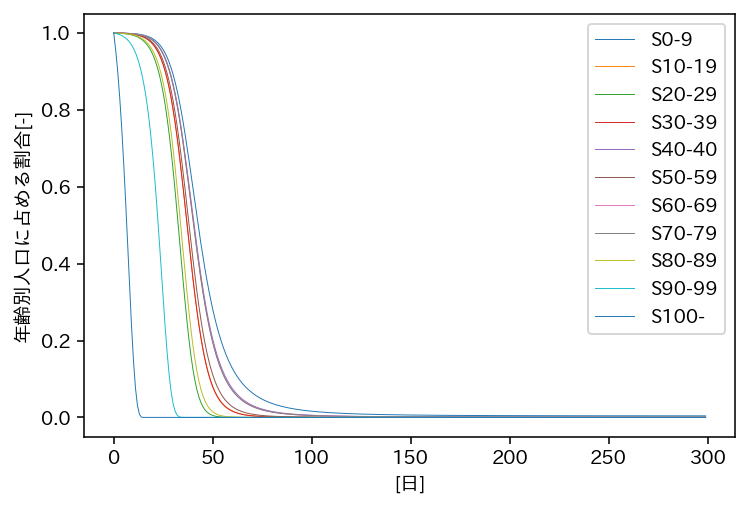

In [23]:
# plot

T=range(0,NUM_OF_DAYS)

#plt.plot([s[0] for s in S], label="S", linewidth=.5)
#plt.plot([sum([ss for ss in s]) for s in S], label="S", linewidth=.5)
plt.plot([sum([ii for ii in i]) for i in I], label="I", linewidth=.5)
plt.plot([sum([rr for rr in r]) for r in R], label="R", linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for k, v in enumerate(GROUPS):
    plt.plot([i[k][0] for i in I], label="I"+str(v), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for k, v in enumerate(GROUPS):
    plt.plot([r[k][0] for r in R], label="R"+str(v), linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("[人]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

for k, v in enumerate(GROUPS):
    plt.plot([s[k][0]/N[k] for s in S], label="S"+str(v), linewidth=.5)
#plt.plot([r[] for r in R], label="R", linewidth=.5)
plt.xlabel("[日]")
plt.ylabel("年齢別人口に占める割合[-]")
plt.legend(bbox_to_anchor=(1,1))
plt.show()
